# Anthropogenic heat from buildings

This notebook is used to process building energy use, analyze data, and ultimately produce the anthropogenic heat flux (AHF) from buildings for the Greater Los Angeles (LA) region.

In [1]:
# load necessary packages 
%matplotlib inline
import os
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib

## Import data from data repositories

Download Energy Atlas data from Kaggle repo (if not already in local directory)

In [2]:
energy_atlas_data_path = Path('data/energy_atlas')
if not os.path.isdir(energy_atlas_data_path): # if data directory does not exist (i.e., data not downloaded yet)
    # initialize kaggle API
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()

    # download from my Kaggle dataset page
    dataset = 'josephko/la-energy-atlas-2016'
    download_path = Path('data/energy_atlas')
    api.dataset_download_files(dataset, download_path) # downloads all data in zip file
    
    # unzip and remove zip file
    zip_file = download_path / 'la-energy-atlas-2016.zip'
    with zipfile.ZipFile(zip_file) as file:
        file.extractall(download_path)
    os.remove(zip_file)


Import Energy Atlas data into dataframes

In [46]:
usage_file = energy_atlas_data_path / 'usage_bld_btu.csv'
usage_bld_btu = pd.read_csv(usage_file, na_values = ['NaN'])
print(usage_bld_btu._is_copy)
usage_bld_btu = usage_bld_btu.loc[usage_bld_btu['usage'] != 'masked'].copy()
print(usage_bld_btu._is_copy)

# # TESTING 
# cols = usage_bld_btu.columns.drop(['geo_id', 'usetype', 'name'])
# usage_bld_btu.loc[:,cols] = usage_bld_btu.loc[:, cols].apply(pd.to_numeric, errors = 'coerce')

usage_bld_btu

None
None


,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
1,cities_1,4820002.0,307943899305.5130,552251718.742479,46351.2600,commercial,2016,0.729374077813779,0.27062592218622,agoura hills,NaN,NaN
2,cities_1,8916603.0,371532651324.6650,75308184.502491,34141.0256,condo,2016,0.401411831210031,0.598588168789969,agoura hills,NaN,NaN
5,cities_1,742420.0,13880934410.2757,551195246.006691,27645.8101,multi_family,2016,0.494247031872507,0.505752968127493,agoura hills,NaN,NaN
9,cities_1,14582828.0,607423395220.2180,77423013.203888,34664.6960,res_total,2016,0.39367841860114,0.606321581398859,agoura hills,20236.0,30016969.5207
10,cities_1,4871778.0,185856698385.1830,81616936.012045,36044.4204,single_family,2016,0.404338301428263,0.595661698571739,agoura hills,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5762,neighborhoods_99,NaN,NaN,NaN,NaN,condo,2016,NaN,NaN,carthay,NaN,NaN
5765,neighborhoods_99,1896313.0,62287216523.5229,123951796.951531,33829.0805,multi_family,2016,0.315242860698158,0.684757139301843,carthay,NaN,NaN
5769,neighborhoods_99,3452091.0,135011350072.0880,92115112.9332543,35663.1742,res_total,2016,0.325581077358624,0.674418922641377,carthay,5201.0,25958729.1044
5770,neighborhoods_99,1525718.0,61785646186.9359,79130635.2189765,37415.2632,single_family,2016,0.352719384793062,0.647280615206937,carthay,NaN,NaN


## Descriptive analysis of Energy Atlas data

In [25]:
# How many different usetype categories?
usage_bld_btu['usetype'].unique()

array(['commercial', 'condo', 'multi_family', 'res_total',
       'single_family', 'residential_other', 'residential_uncat', 'uncat',
       'other', 'agriculture', 'industrial', 'institutional'],
      dtype=object)

In [47]:
# subset only neighborhood-aggregated records
usage_bld_btu_neighborhoods = usage_bld_btu.loc[usage_bld_btu['geo_id'].str.contains('neighborhoods')].copy()
usage_bld_btu_neighborhoods

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
2508,neighborhoods_100,NaN,NaN,NaN,NaN,agriculture,2016,NaN,NaN,castaic,NaN,NaN
2510,neighborhoods_100,50416.0,17454020756.4437,167783654.462462,99221.5579,condo,2016,0.435955215576706,0.564044784423294,castaic,NaN,NaN
2513,neighborhoods_100,393143.0,17258134365.3469,246879735.295895,41104.1345,multi_family,2016,0.467833143488719,0.532166856511281,castaic,NaN,NaN
2517,neighborhoods_100,10257155.0,407638305980.8140,67963094.2093305,34019.6952,res_total,2016,0.420109676951605,0.579890323048396,castaic,16843.0,24202238.6737
2518,neighborhoods_100,9785358.0,332670161278.2370,67848358.577214,33948.9682,single_family,2016,0.440066781397191,0.559933218602811,castaic,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5762,neighborhoods_99,NaN,NaN,NaN,NaN,condo,2016,NaN,NaN,carthay,NaN,NaN
5765,neighborhoods_99,1896313.0,62287216523.5229,123951796.951531,33829.0805,multi_family,2016,0.315242860698158,0.684757139301843,carthay,NaN,NaN
5769,neighborhoods_99,3452091.0,135011350072.0880,92115112.9332543,35663.1742,res_total,2016,0.325581077358624,0.674418922641377,carthay,5201.0,25958729.1044
5770,neighborhoods_99,1525718.0,61785646186.9359,79130635.2189765,37415.2632,single_family,2016,0.352719384793062,0.647280615206937,carthay,NaN,NaN


In [48]:
# further subset for only residential
usage_bld_btu_neighborhoods_res = usage_bld_btu_neighborhoods.loc[usage_bld_btu_neighborhoods['usetype'] == 'res_total'].copy()
usage_bld_btu_neighborhoods_res

,geo_id,sqft,usage,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,name,pop,usage_percap
2517,neighborhoods_100,10257155.0,407638305980.8140,67963094.2093305,34019.6952,res_total,2016,0.420109676951605,0.579890323048396,castaic,16843.0,24202238.6737
2529,neighborhoods_101,16985227.0,723622131067.8330,70883647.5557745,27792.0387,res_total,2016,0.431833803513616,0.568166196486386,castaic canyons,46516.0,15556413.5151
2541,neighborhoods_102,7467333.0,347798111701.7480,64476854.984696,42876.8815,res_total,2016,0.306653971887979,0.693346028112021,central-alameda,43628.0,7971901.3409
2553,neighborhoods_103,1691063.0,343647647368.2600,81255336.5714998,39514.2308,res_total,2016,0.379313540354248,0.620686459645752,century city,5516.0,62300153.6201
2565,neighborhoods_104,NaN,NaN,NaN,NaN,res_total,2016,NaN,NaN,cerritos,49956.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5721,neighborhoods_95,NaN,NaN,NaN,NaN,res_total,2016,NaN,NaN,burbank,104565.0,NaN
5733,neighborhoods_96,19994907.0,970266915157.7920,93994577.7850155,34430.9786,res_total,2016,0.405000968722349,0.594999031277651,calabasas,25656.0,37818323.7901
5745,neighborhoods_97,18630293.0,978973578703.2940,66743038.7082336,44255.3542,res_total,2016,0.42166661879379,0.57833338120621,canoga park,61801.0,15840740.0965
5757,neighborhoods_98,30620822.0,1376154814380.9200,48479134.331124,32486.7605,res_total,2016,0.353818600303716,0.646181399696282,carson,92200.0,14925757.2059


In [49]:
print(usage_bld_btu_neighborhoods_res._is_copy)

None


In [30]:
# testing SettingWithCopyWarning with test df
df = pd.DataFrame({'A': ['1', '2', 'NaN'], 'B': ['1', 'NaN', '3'], 'C': ['1', '2', '3']})
cols = df.columns.drop(['C'])
df.loc[:, cols] = df[cols].apply(pd.to_numeric, errors = 'coerce')
df

,A,B,C
0,1.0,1.0,1
1,2.0,NaN,2
2,NaN,3.0,3


In [50]:
# convert appropriate columns to numeric
cols = usage_bld_btu_neighborhoods_res.columns.drop(['geo_id', 'usetype', 'name'])
usage_bld_btu_neighborhoods_res.loc[:,cols] = usage_bld_btu_neighborhoods_res[cols].apply(pd.to_numeric, errors = 'coerce')
usage_bld_btu_neighborhoods_res.dtypes

geo_id             object
sqft              float64
usage             float64
usage_med         float64
usage_med_sqft    float64
usetype            object
year                int64
pct_elec          float64
pct_ng            float64
name               object
pop               float64
usage_percap      float64
dtype: object

<AxesSubplot:ylabel='Frequency'>

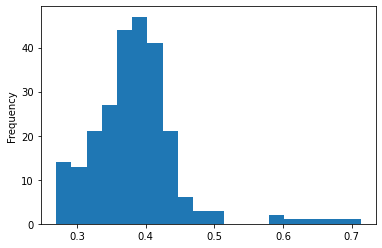

In [54]:
# distribution of pct_elec
usage_bld_btu_neighborhoods_res['pct_elec'] = pd.to_numeric(usage_bld_btu_neighborhoods_res['pct_elec'])
usage_bld_btu_neighborhoods_res['pct_elec'].plot.hist(bins = 20) 